# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here].

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# так как с !wget здесь будет ошибка, т.к для каггла нужна авторизация, то только
# так скачивать данные с каггла

from google.colab import files

# получаем kaggle.json с каггла на аккаунт -> API (create new token)
files.upload()  # Загрузите сюда файл kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniilsergeevda","key":"098ff7c82a39bb689669c1816b8b6844"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle
!kaggle competitions download -c job-salary-prediction -f Train_rev1.zip

In [6]:
data = pd.read_csv("/content/Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [ ]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
198207,71847498,Field Sales Executive Freight,"Our client based in Colnbrook, Berkshire is a ...","Slough, Berkshire Berkshire South East",Slough,NaN,permanent,Parkside Recruitment Staines,Sales Jobs,"28000 - 31000 per annum + Comisson, Benefits",29500,totaljobs.com
230840,72453976,IMMEDIATE START Customer Service & Sales Oppo...,IMMEDIATE START Customer Service Sales Opport...,Liverpool Merseyside North West,Liverpool,NaN,permanent,Red Planet Marketing,Sales Jobs,250-500pw - Ave Earnings,18000,totaljobs.com
84162,69067690,Business Development/Sales Electrical Connectors,Eden Scott s client brings over 30 years of se...,"Aberdeen,",Aberdeen,NaN,NaN,Eden Scott,Sales Jobs,35000 - 50000 UK Pounds/year,42500,OilCareers.com


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

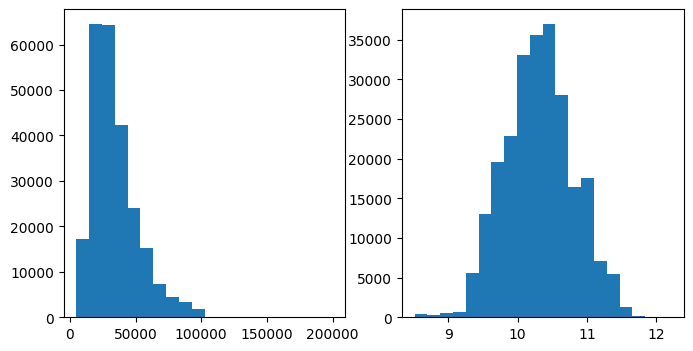

In [7]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [8]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
242039,72680180,Payroll Benefits Administrator Southampton *...,Payroll Benefits Administrator Southampton *...,Southampton,Southampton,NaN,permanent,Bond Williams Limited,HR & Recruitment Jobs,18k pa + Excellent benefits,18000,jobsite.co.uk,9.798182
196941,71829003,German Advisor At Home in Cork,You will be required to follow standard diagno...,"Cork, Republic of Irel",UK,NaN,permanent,mgi recruitment,Customer Services Jobs,20000 - 24000,22000,Multilingualvacancies,9.998843
150145,70764919,Asbestos Regional Manager,Job Ref: **** Regional Manager Salary negotiab...,"Newport, Gwent",UK,NaN,permanent,Premiere People,Other/General Jobs,30000/annum c30000 + company vehicle,30000,cv-library.co.uk,10.308986


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [9]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

' '.join(tokenizer.tokenize(data["FullDescription"].iloc[2])).lower()

'mathematical modeller / simulation analyst / operational analyst basingstoke , hampshire up to **** k aae pension contribution , private medical and dental the opportunity our client is an independent consultancy firm which has an opportunity for a data analyst with 35 years experience . the role will require the successful candidate to demonstrate their ability to analyse a problem and arrive at a solution , with varying levels of data being available . essential skills thorough knowledge of excel and proven ability to utilise this to create powerful decision support models experience in modelling and simulation techniques , experience of techniques such as discrete event simulation and / or sd modelling mathematical / scientific background minimum degree qualified proven analytical and problem solving skills self starter ability to develop solid working relationships in addition to formal qualifications and experience , the successful candidate will require excellent written and ver

In [10]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [11]:
def function_for_preprocess(string: str) -> str:
    string = str(string)
    return ' '.join(tokenizer.tokenize(string)).lower()

In [12]:
data['FullDescription'] = data['FullDescription'].apply(function_for_preprocess)
data['Title'] = data['Title'].apply(function_for_preprocess)

Now we can assume that our text is a space-separated list of tokens:

In [13]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [14]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for i in data['FullDescription']:
    for token in i.split():
        token_counts[token] += 1
for i in data['Title']:
    for token in i.split():
        token_counts[token] += 1

In [15]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


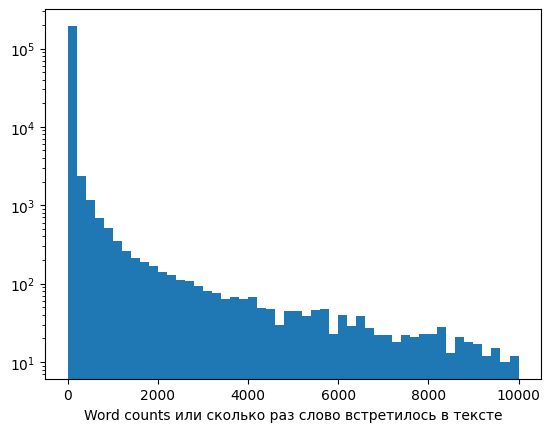

In [16]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts или сколько раз слово встретилось в тексте");
# а по оси y - кол-во таких слов
# нап. у нас есть очень много слов, которые встречались 1 раз (слева)
# и у нас есть очень мало слов, которые встречались 10_000 раз (справа)
# это называется законом Ципфа

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [17]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [18]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [19]:
tokens.index('the')

30746

In [20]:
token_to_id = dict()
for i in range(len(tokens)):
    token_to_id[tokens[i]] = tokens.index(tokens[i])

In [21]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


In [22]:
token_to_id.get('the')

30746

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [23]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [24]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [25]:
data[categorical_columns].sample(3)

,Category,Company,LocationNormalized,ContractType,ContractTime
17806,Sales Jobs,Randstad Business Support,Devon,NaN,NaN
150415,Property Jobs,Klier Solutions,UK,NaN,permanent
43721,Accounting & Finance Jobs,Hays A F,Swindon,full_time,permanent


In [26]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))
# в результате one-hot-encoding категориальных фичей (ну точнее vectorizer)

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [27]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]}
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [29]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]], device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [49]:
btch = make_batch(data_train[:3], max_len=10)

In [50]:
emb = nn.Embedding(len(tokens), 100).to('cuda')

In [51]:
print(emb(btch['Title']).shape) # где 3 - кол-во примеров (строк), 7 - кол-во токенов в заголовке
embed = emb(btch['Title'])
# 100 - размер эмбеддингов

torch.Size([3, 7, 100])


In [52]:
embed = embed.permute(0, 2, 1).to('cuda')
embed.shape

torch.Size([3, 100, 7])

In [53]:
layer = nn.Conv1d(100, 64, kernel_size=3, stride=1).to('cuda')

In [54]:
layer(embed).shape # 5 - кол-во триграмм

torch.Size([3, 64, 5])

In [55]:
# global pooling
pool_test = torch.max(layer(embed), dim=-1).values

In [56]:
pool_test.shape

torch.Size([3, 64])

In [64]:
print(btch['Categorical'].shape) # one-hot-encoding here, thus 3768 second dim

torch.Size([3, 3768])


In [66]:
lin = nn.Linear(3768, 64)

In [68]:
lin(btch['Categorical']).shape

torch.Size([3, 64])

In [109]:
a = torch.tensor([[1, 2], [3, 4], [5, 6]])
b = torch.tensor([[1, 2], [3, 4], [5, 6]])
c = torch.tensor([[1, 2], [3, 4], [5, 6]])

In [110]:
torch.cat((a, b, c), dim=0)

tensor([[1, 2],
        [3, 4],
        [5, 6],
        [1, 2],
        [3, 4],
        [5, 6],
        [1, 2],
        [3, 4],
        [5, 6]])

In [111]:
torch.cat((a, b, c), dim=0).flatten()

tensor([1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6])

In [90]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=100)
        self.conv_title = nn.Conv1d(in_channels=100, out_channels=hid_size, kernel_size=3, stride=1, padding=1) # in_channels=200, так как каждое измерение - 1 канал
        self.conv_descript = nn.Conv1d(in_channels=100, out_channels=hid_size, kernel_size=3, stride=1, padding=1)
        self.fc_categ = nn.Linear(n_cat_features, hid_size)
        self.fc_classifier = nn.Linear(hid_size*3, 1)

    def forward(self, batch):
        out_title = self.conv_title(self.emb(batch['Title']).permute(0, 2, 1))
        out_title = torch.max(out_title, dim=-1).values # global pooling --> (len_str (len_seq), 64)
        #print(out_title.shape) --> torch.Size([100, 64])
        out_description = self.conv_descript(self.emb(batch['FullDescription']).permute(0, 2, 1))
        out_description = torch.max(out_description, dim=-1).values # global pooling --> (len_str (len_seq), 64)
        #print(out_description.shape) --> torch.Size([100, 64])
        out_categ = self.fc_categ(batch['Categorical'])
        #print(out_categ.shape) --> torch.Size([100, 64])
        out = torch.cat((out_title, out_description, out_categ), dim=1)
        #print(out.shape) --> torch.Size([100, 192])
        out = self.fc_classifier(out)
        #print(out.shape) --> torch.Size([100, 1]) и уберем вторую размерность
        return out.squeeze(1)

In [91]:
model = SalaryPredictor()

In [92]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])

assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [93]:
dummy_loss

tensor(112.2782, device='cuda:0', grad_fn=<MseLossBackward0>)

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [94]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [95]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [96]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [97]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.18706
Mean absolute error: 0.35127
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10662
Mean absolute error: 0.24834
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09791
Mean absolute error: 0.23667
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10129
Mean absolute error: 0.24461
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08890
Mean absolute error: 0.22514


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [98]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [99]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [100]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [101]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [102]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 25052
Salary (gbp): tensor([21463.1250])


maintenance engineer multi skilled

multi skilled maintenance engineer the company are a large national utilities business who deliver , planned , corrective and emergency maintenance to water treatment works and local pumping stations in the oxfordshire area they are currently looking for a multi skilled maintenance technician for a field based role in the banbury / oxfordshire area the job will involve delivering planned , corrective and emergency maintenance to water production plant and pumping stations , the technician will be required to inspect , maintain , fault diagnose , test , install , modify or repair as appropriate on mechanical / electrical plant and equipment . you will carry out all aspects of mechanical / electrical planned and breakdown maintenance on plant and equipment used in the water industry . selfmotivated , organised and able to work unsupervised you will be a committed member of the team , working on various sites in the banbury and oxfordshire area qualifications and requirements the ideal person will have : ideally time served or with a recognised apprenticeship , city & guilds part **** or equivalent in mechanical / electrical engineering . experience of **** phase motors , starters , pumps , valves , general mechanical process plant and control panels , fault finding and rectification is required . due to the nature of the work , you will be willing to work in confined spaces and in all weather conditions . you will have the ability to work with minimum supervision , under own initiative to design and standards . previous experience of working as a mobile technician or site based maintenance engineer would be desirable . this is a great opportunity to join a leading utilities company in a varied field service role . for details please contact david UNK at reed engineering on ( apply online only ) or email

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)